In [1]:
# Advanced Data Analytics Final Project
# Aaron Forrest, Ajay Parthasarathy, Grant Tilson
# 5/3/21

## Need to pip install import_ipynb to get this functionality
## Meant to give access to other .ipynb notebooks to use as modules
## Must also create a blank file in this folder titled '__init__.ipynb'
import import_ipynb

In [2]:
# Helpful Links
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python
# https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
# https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# https://www.kaggle.com/kabure/credit-card-fraud-prediction-rf-smote

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from scipy import stats

In [4]:
# SMOTE imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [5]:
# Import Other Files
# Must compile the other two files of the same name prior to running this block
import GeneratePlots
import Random_Forest

importing Jupyter notebook from GeneratePlots.ipynb
importing Jupyter notebook from Random_Forest.ipynb


In [6]:
# Create name for text files
random_forest_file_name="Random_Forest_Results.txt"

# Truncate them to clear their previous contents
random_forest_file=open(random_forest_file_name,"a")
random_forest_file.truncate(0)
random_forest_file.close()

In [7]:
# Set plotting style
plt.style.use('ggplot')

In [8]:
# Import credit card transaction data
df_creditcard = pd.read_csv('creditcard.csv')

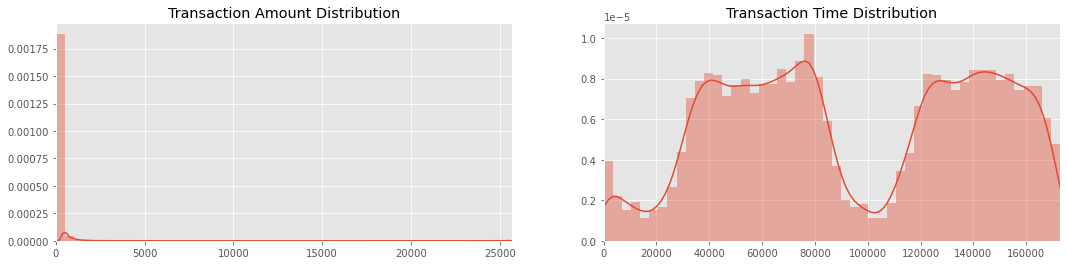

In [9]:
# Generate plots of transaction amount and time distributions
GeneratePlots.gen_amount_time_plot(df_creditcard)

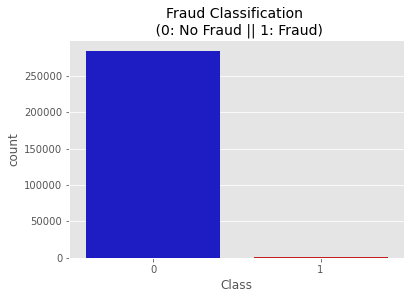

In [10]:
GeneratePlots.gen_data_class(df_creditcard)

In [11]:
# The V* features are scaled but the Time and Amount features are not scaled
# This scales those two features for proper analysis
robust_scaler=RobustScaler()

# Scale new values
df_creditcard['Amount_Scaled']=robust_scaler.fit_transform(df_creditcard['Amount'].values.reshape(-1,1))
df_creditcard['Time_Scaled']=robust_scaler.fit_transform(df_creditcard['Time'].values.reshape(-1,1))

# Drop old time and amount features
df_creditcard.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
# Need to rearrange order of columns to make sure that Class is the last column
scaled_amount_placeholder=df_creditcard['Amount_Scaled']
scaled_time_placeholder=df_creditcard['Time_Scaled']
df_creditcard.drop(['Amount_Scaled','Time_Scaled'], axis=1, inplace=True)
df_creditcard.insert(0,'Amount_Scaled',scaled_amount_placeholder)
df_creditcard.insert(1,'Time_Scaled',scaled_time_placeholder)

In [13]:
# Split Data into test and train datasets
# X values are V* and Amount and Y values are 1 for fraud and 0 for not fraud
# Current Train dataset is 70% of the total dataset
X=df_creditcard.iloc[:,0:30]
y=df_creditcard.iloc[:,30]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3)

In [14]:
# Run of the random forest model using scaled dataset
scaled_feature_imp=Random_Forest.run_random_forest(df_creditcard, X_train, X_test, y_train, y_test,"Scaled", random_forest_file_name)

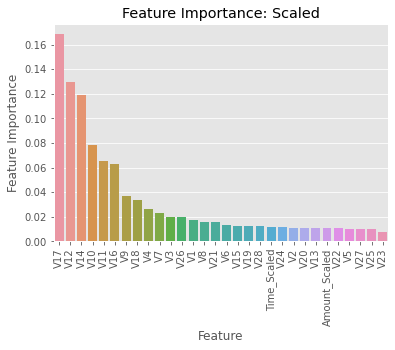

In [15]:
# Generate Feature Importance Plot
GeneratePlots.gen_feature_plot(df_creditcard, scaled_feature_imp,"Scaled")

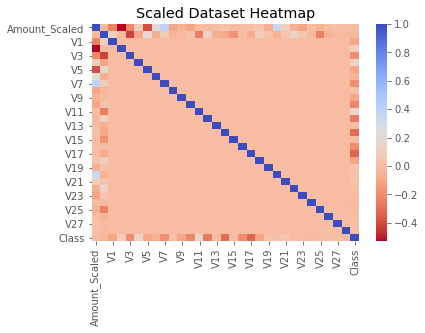

In [16]:
# Generate heatmap of oversampled training data
GeneratePlots.gen_heatmap_plot(df_creditcard, "Scaled")

In [17]:
# Oversample the Fraud cases in the training dataset
OS=SMOTE()
X_train_os,y_train_os=OS.fit_resample(X_train,y_train)

In [18]:
# Run of random forest model using oversampled training data
oversampled_feature_imp=Random_Forest.run_random_forest(df_creditcard, X_train_os, X_test, y_train_os, y_test,"Oversampled", random_forest_file_name)

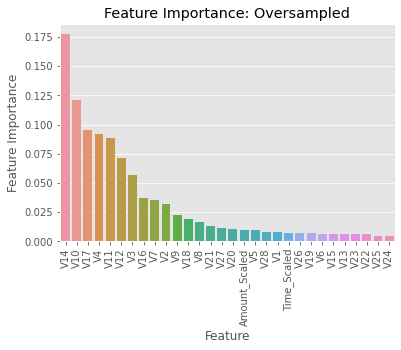

In [19]:
# Generate Feature Importance Plot for Oversampled Data
GeneratePlots.gen_feature_plot(df_creditcard, oversampled_feature_imp,"Oversampled")

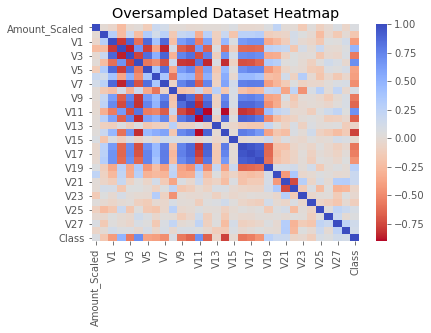

In [20]:
# Append training data to create heatmap for oversampled training set
df_train_oversampled = X_train_os
df_train_oversampled['Class']=y_train_os

# Generate heatmap of oversampled training data
GeneratePlots.gen_heatmap_plot(df_train_oversampled,"Oversampled")

In [21]:
# Undersample the Not Fraud cases
under = RandomUnderSampler(sampling_strategy=1)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_us, y_train_us = pipeline.fit_resample(X_train, y_train)

In [22]:
# Run of random forest model using oversampled training data
undersampled_feature_imp=Random_Forest.run_random_forest(df_creditcard, X_train_us, X_test, y_train_us, y_test,"Undersampled", random_forest_file_name)

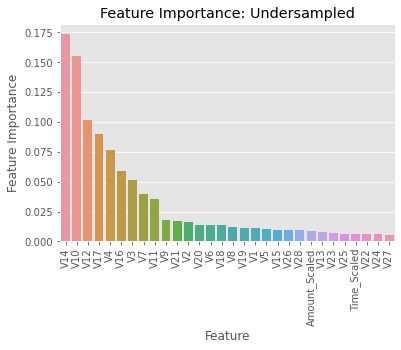

In [23]:
# Generate Feature Importance Plot for Oversampled Data
GeneratePlots.gen_feature_plot(df_creditcard, undersampled_feature_imp,"Undersampled")

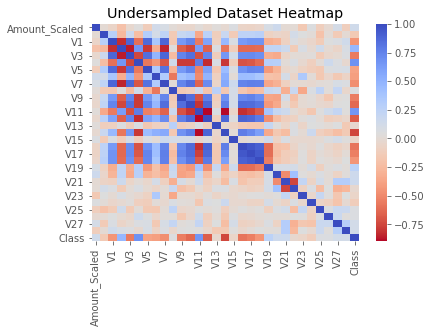

In [24]:
# Append training data to create heatmap for undersampled training set
df_train_undersampled = X_train_us
df_train_undersampled['Class']=y_train_us

# Generate heatmap of oversampled training data
GeneratePlots.gen_heatmap_plot(df_train_undersampled,"Undersampled")

In [25]:
# Pipeline over and undersample to see mixed results
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_os_us, y_train_os_us = pipeline.fit_resample(X_train, y_train)

In [26]:
# Run of random forest model using over and under sampled training data
overundersampled_feature_imp=Random_Forest.run_random_forest(df_creditcard, X_train_os_us, X_test, y_train_os_us, y_test,"Over_and_Undersampled", random_forest_file_name)

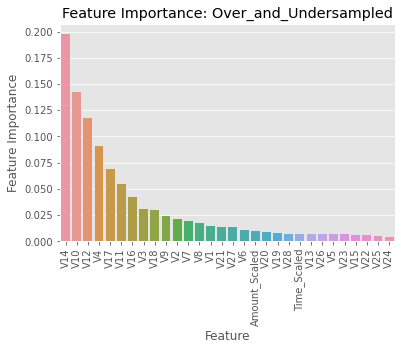

In [27]:
# Generate Feature Importance Plot for Over and under sampled Data
GeneratePlots.gen_feature_plot(df_creditcard, overundersampled_feature_imp,"Over_and_Undersampled")

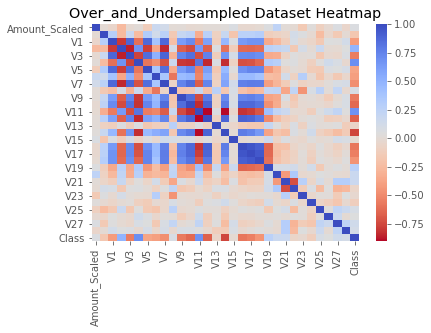

In [28]:
# Append training data to create heatmap for undersampled training set
df_train_overundersampled = X_train_os_us
df_train_overundersampled['Class']=y_train_os_us

# Generate heatmap of oversampled training data
GeneratePlots.gen_heatmap_plot(df_train_overundersampled,"Over_and_Undersampled")